In [1]:
import e3x
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpy.testing as npt

from scipy.special import spherical_jn

from euclidean_fast_attention.fast_attention import EuclideanFastAttention

# Invariant Example for Two Nodes

First we create positions for two nodes in Euclidean space which are randomaly translated and rotated. 

In [2]:
# Choose the values for x. This corresponds to different separations. max(x) = r_max in Eq. 24.
x = jnp.linspace(0, 1, 512)

# Draw random positions for the first atom / node.
vec_key, rot_key = jax.random.split(jax.random.PRNGKey(0))
v1 = jax.random.normal(vec_key, (x.size, 3))

# Create randomly rotated displacement vectors of length [min(x), ..., max(x)].
rot = e3x.so3.random_rotation(rot_key, num=x.shape[0])
u = jnp.einsum("...a,...ab->...b", jnp.zeros((x.size, 3)).at[:, 0].set(x), rot)

# Obtain the position of the second node / atom.
v2 = v1 + u

In [3]:
# Create an array for the positions.

pos = jnp.stack(
    [
        v1, v2
    ],
    axis=1
)

# We see that there are 512 geometries (molecular structures)
# Each consisting of two node positions in Euclidean space.
pos.shape

(512, 2, 3)

In [4]:
# Lets extract a single geometry and print the pairwise distance.

pos_single = pos[200]

jnp.linalg.norm(pos_single[0] - pos_single[1], axis=-1)

Array(0.3913894, dtype=float32)

In [7]:
# Next lets look at the options for the EuclideanFastAttention module.
help(EuclideanFastAttention)

Help on class EuclideanFastAttention in module euclidean_fast_attention.fast_attention:

class EuclideanFastAttention(flax.linen.module.Module)
 |  EuclideanFastAttention(lebedev_num: int = 6, parametrized: bool = True, num_features_qk: Optional[int] = None, max_degree_qk: Optional[int] = None, include_pseudotensors_qk: Optional[bool] = None, num_features_v: Optional[int] = None, max_degree_v: Optional[int] = None, include_pseudotensors_v: Optional[bool] = None, activation_fn: Optional[Callable[..., Any]] = <function EuclideanFastAttention.<lambda> at 0x123b04400>, tensor_integration: bool = False, ti_max_degree_sph: Optional[int] = None, ti_include_pseudotensors: Optional[bool] = None, ti_max_degree: Optional[int] = None, ti_parametrize_coupling_paths: bool = False, ti_degree_scaling_constants: Optional[Sequence[float]] = None, epe_frequencies_init_fn: Optional[Callable[..., Any]] = <function frequency_init_fn at 0x123adb880>, epe_num_frequencies: Optional[int] = None, epe_max_frequen

TypeError: 'NoneType' object is not subscriptable

In [30]:
# Choose b_max, as given in Eq. 24.
b_max = 4 * jnp.pi

# We now initialize an EFA module.
efa = EuclideanFastAttention(
    lebedev_num=50,
    parametrized=False,
    epe_max_frequency=b_max,
    epe_max_length=jnp.max(x),
    tensor_integration=False
)

# Assume a feature dimension of 2 for the two nodes.
# Must be at least 2 since we have two channles per frequency (Eq. 20).
inputs_single = jnp.array(
    [
        [1., 1.], 
        [1., 1.],
    ]
)  # (2, 1)

# Bring them into the e3x shape (num_nodes, 1 or 2, (max_degree + 1)**2, num_features)
inputs_single = inputs_single[:, None, None, :]

# Positions are already in shape (num_nodes, 3)

# batch_segments and graph_mask are trivial in the case of 
# only a single graph / molecule. For general information see help(EuclideanFastAttention) above.
batch_segments_single = jnp.array([0, 0], dtype=int)  # (num_nodes)
graph_mask_single = jnp.array([True])  # (num_graphs)

params = efa.init(
    jax.random.PRNGKey(0),
    inputs=inputs_single,
    positions=pos_single,
    batch_segments=batch_segments_single,
    graph_mask=graph_mask_single
)

out = efa.apply(
    params,
    inputs=inputs_single,
    positions=pos_single,
    batch_segments=batch_segments_single,
    graph_mask=graph_mask_single
)

print(out.shape)
print(out)

(2, 1, 1, 2)
[[[[1.1327921 1.1327921]]]


 [[[1.1327918 1.1327918]]]]


In [31]:
# Lets now evaluate at all positions
# One trivial way is to just iterate over all positions.

model_predictions = []

for p in pos:
    out = efa.apply(
        params,
        inputs=inputs_single,
        positions=p,
        batch_segments=batch_segments_single,
        graph_mask=graph_mask_single
    )
    
    model_predictions.append(out)

model_predictions = jnp.stack(model_predictions, axis=0)

Lets plot the model predictions as a function of x. We see two things:

1) A sinc like function, which is scaled and shifted (compared to a standard sinc function) due to self-interations and the choice of feature entries.

2) Starting from some value x, the prediction starts to become noisy. This corresponds to the region where the Lebedev quadrature breaks down (the prediction is not rotationally invariant anymore), since it has too little number of grid points. More specifically, the reason is that we chose `num_lebedev = 50` which is too small for the chosen value of `b_max = 4*pi`. Following Tab. S3 in the paper, for this value of `b_max` the one requires `num_lebedev = 194`. You can reapeat the experiment by changing this in the cell two above and see how things behave now.

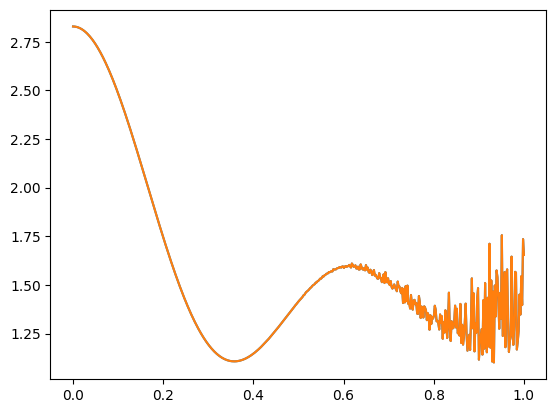

In [46]:
plt.plot(x, model_predictions[:, 0, 0, 0, :]);

In [43]:
# Instead of using a for-loop we can also do this in a single call.
# Lets start by creating batched_positions, such that
# [r_11, r_12, r_21, r_22, r_31, r32, ...] where the first subscript indicates
# the number of the graph and the second the number of the node.
pos_batched = pos.reshape(-1, 3)  # (2*len(x), 3)

# We need to create input features for all nodes.
inputs_batched = jnp.repeat(
    jnp.array([1, 1])[None], 
    int(2*x.shape[0]), axis=0
)

inputs_batched = inputs_batched[:, None, None, :]

# We now need to also create batch_segments which are of the form
# [0, 0, 1, 1, 2, 2, ...] and denote the batch / graph the nodes belong to.
batch_segments = jnp.stack(
    [jnp.arange(x.shape[0]), jnp.arange(x.shape[0])], axis=1
).reshape(-1)

# And also the graph mask, given here as all Trues since no padding graphs are involved.
graph_mask_batched = jnp.array([True]*x.shape[0])

# For details on graph batching see also
# https://e3x.readthedocs.io/stable/examples/md17_ethanol.html and
# https://jraph.readthedocs.io/en/latest/api.html#batching-padding-utilities

out = efa.apply(
    params,
    inputs=inputs_batched,
    positions=pos_batched,
    batch_segments=batch_segments,
    graph_mask=graph_mask_batched
)

out.shape

(1024, 1, 1, 2)

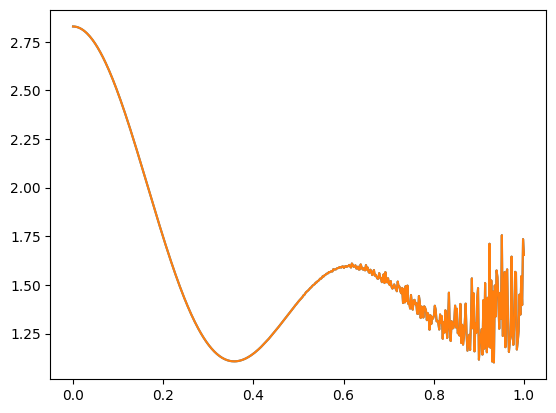

In [45]:
# We see that the leading dimension now has 1024 entries since the nodes share the leading axis
# i.e. they are batched along it. Thus, to only access the entries at the first node we only take every
# second entry which gives the same plot as above.

plt.plot(x, out[::2, 0, 0, :]);

# Equivariant Case

We now consider the case where we also perform a tensor integration according to Eq. 23. This gives higher order Bessel function for the different degrees which we will showcase again for a two atom system below.

In [75]:
efa = EuclideanFastAttention(
    lebedev_num=50,
    parametrized=False,
    epe_max_frequency=b_max,
    epe_max_length=jnp.max(x),
    tensor_integration=True,
    ti_include_pseudotensors=False,
    ti_max_degree_sph=2,
    ti_max_degree=2,
)

# We directly consider the batched case, no with different features at node 1 and node 2.
inputs1 = jnp.array([1, 0.5])
inputs2 = jnp.array([.3, 1.4])

inputs_batched = jnp.repeat(
    jnp.stack([inputs1, inputs2], axis=0)[None], 
    x.shape[0], 
    axis=0
).reshape(-1, 2)

inputs_batched = inputs_batched[:, None, None, :]

params = efa.init(
    jax.random.PRNGKey(0),
    inputs=inputs_batched,
    positions=pos_batched,
    batch_segments=batch_segments,
    graph_mask=graph_mask_batched
)

out = efa.apply(
    params,
    inputs=inputs_batched,
    positions=pos_batched,
    batch_segments=batch_segments,
    graph_mask=jnp.array([True]*x.shape[0])
)

In [78]:
out.shape

(1024, 1, 9, 2)

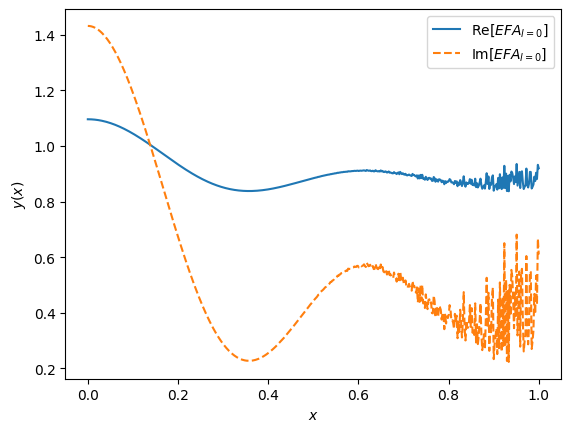

In [76]:
# l = 0
y_efa_re_l0 = out[::2, 0, 0, 0]
y_efa_im_l0 = out[::2, 0, 0, 1]

plt.plot(x, y_efa_re_l0, label='Re$[EFA_{l=0}]$')
plt.plot(x, y_efa_im_l0, label='Im$[EFA_{l=0}]$', ls='--')

plt.xlabel('$x$')
plt.ylabel('$y(x)$')
plt.legend();

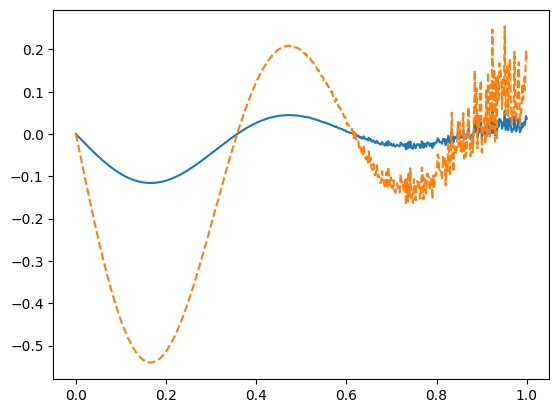

In [88]:
# For the higher degrees, we rotate the features back, as this allows to see the Bessel 
# functions scaled by the feature entries.

wigner_d = e3x.so3.wigner_d(rot, max_degree=2)
out_z = jnp.einsum('...paf,...ba->...pbf', out[::2], wigner_d)  # reversed a and b to take transpose

# Lets start looking at l = 1. Again we see that as soon as the Lebev quadrature is violated the model
# starts to deviate corresponding to violating rotational equivariance of the l=1 features.

y_efa_re_l1 = out_z[:, 0, 1, 0]
y_efa_im_l1 = out_z[:, 0, 1, 1]

plt.plot(x, y_efa_re_l1, label='Re$[EFA_{l=1}]$')
plt.plot(x, y_efa_im_l1, label='Im$[EFA_{l=1}]$', ls='--')

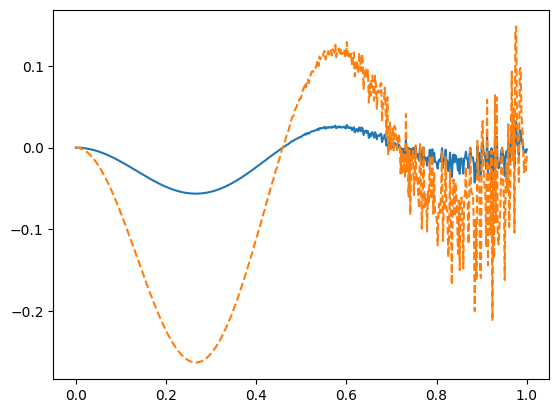

In [90]:
# For the higher degrees, we rotate the features back to the z axis, as this allows to see the Bessel 
# functions scaled by the feature entries.

wigner_d = e3x.so3.wigner_d(rot, max_degree=2)
out_z = jnp.einsum('...paf,...ba->...pbf', out[::2], wigner_d)  # reversed a and b to take transpose

# Now for l = 2.

y_efa_re_l2 = out_z[:, 0, 4, 0]
y_efa_im_l2 = out_z[:, 0, 4, 1]

plt.plot(x, y_efa_re_l2, label='Re$[EFA_{l=1}]$')
plt.plot(x, y_efa_im_l2, label='Im$[EFA_{l=1}]$', ls='--')